In [22]:
from core.Classifier import Classifier
from core.Model import Model
import xlrd
import scipy
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score,pairwise_distances, accuracy_score, f1_score
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import operator
import rank_bm25
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import random
import csv
import sys
import os
from joblib import Parallel, delayed
import datetime
import json
from core.Util import *
import requests


_path = '../models-article-classifier'
now = datetime.datetime.now().strftime('%d-%m-%Y')



tqdm_disable = True

args = {}

args['list'] = [
#     '/dados/querys-classificadas/aplicação-da-lama-de-beneficiamento-de-rochas-ornamentais.json',
#     '/dados/querys-classificadas/Aproveitamento-de-rejeitos-de-rochas-ornamentais.json',
#     '/dados/querys-classificadas/Caracterização-da-lama-de-beneficiamento-de-rochas-ornamentais.json',
#     '/dados/querys-classificadas/fabricação-de-materiais-cerâmicos-a-partir-de-resíduos-de-rochas-ornamentias.json',
#     '/dados/querys-classificadas/granite-processing-recycling-of-sludge.json',
#     '/dados/querys-classificadas/incorporation-of-ornamental-stone-sludge-in-cement.json',
#     '/dados/querys-classificadas/incorporation-of-ornamental-stone-sludge-in-ceramics.json',
#     '/dados/querys-classificadas/incorporation-of-ornamental-stone-sludge-in-concrete.json',
#     '/dados/querys-classificadas/lama-de-beneficiamento-de-rochas-ornamentais.json',
#     '/dados/querys-classificadas/Lama-de-beneficiamento-de-rochas-ornamentais.json',
#     '/dados/querys-classificadas/lama-rochas-ornamentais.json',
#     '/dados/querys-classificadas/marble-granite-processing-"recycling-of-sludge".json',
#     '/dados/querys-classificadas/ornamental-stone-processing-waste-recycling.json',
#     '/dados/querys-classificadas/ornamental-stones-waste-recycling.json',
#     '/dados/querys-classificadas/produção-de-vidro-a-partir-de-resíduos-de-rochas-ornamentais.json',
#     '/dados/querys-classificadas/reaproveitamento-de-residuos-de-rochas-ornamentais.json',
#     '/dados/querys-classificadas/Reutilização-da-lama-de-beneficiamento-de-rochas-ornamentais.json',
#     '/dados/querys-classificadas/stone-processing-"recycling-of-sludge".json'
    'data-experimento.json'
]


N_CORES = 16
FEATURE = 'abstract'
METRIC = accuracy_score

In [23]:
# for file_query in args['list']:
print('Lendo JSON de entrada!')
# data = []
# # with open(file_query) as f:
# with open(args['list'][0]) as f:
#     data = json.load(f)


r = requests.get('http://192.168.10.34:8000/api/get/all/query')
querys = r.json()



#Recuperando os artigos
ids = {}
for query in querys:
    for article in query['articles']:
        if not article[0] in ids:
            _id = article[0]
            r = requests.get('http://192.168.10.34:8000/api/get/one/article',json={'_id':_id}).json()
            if len(r)>0:
                r['relevant'] = article[1] 
                r['preditc'] = article[2]
                ids[_id] = r
    query['articles'] = [ids[i] for i in ids]
    


Lendo JSON de entrada!


In [24]:
data = []


for _j, query in enumerate(querys):
    print(query['query'])
    if not query['articles']:
        continue

    _pop = []
    for i in range(len(query['articles'])):
        if not query['articles'][i][FEATURE]:
            _pop.append(i)

    _pop.reverse()
    for i in _pop:
        del query['articles'][i]




    print('Analisando a lingua dos textos!')
    MAX = len(query['articles'])
    aux = Parallel(n_jobs=N_CORES)(delayed(analiser)(query['articles'][i][FEATURE]) for i in tqdm(range(MAX),file=sys.stdout,disable=tqdm_disable))

    t = []
    for i in range(len(query['articles'])):    
        if aux[i]:
            query['articles'][i]['lang'] = [aux[i][0]]
        else:
            t.append(i)
    t.reverse()
    for i in t:
        del query['articles'][i]

    print('Tokenizando os textos!')
    MAX = len(query['articles'])
    t = []
    aux = Parallel(n_jobs=N_CORES)(delayed(filtering)(query['articles'][i][FEATURE],query['articles'][i]['lang']) for i in tqdm(range(MAX),file=sys.stdout,disable=tqdm_disable))
    for i in range(len(query['articles'])):  
        query['articles'][i]['words'] = aux[i]
        if not aux[i]:
            t.append(i)
    t.reverse()
    for i in t:
        del query['articles'][i]

    print('Contando os tokens!')
    MAX = len(query['articles'])
    aux = Parallel(n_jobs=N_CORES)(delayed(TextCounter)(query['articles'][i][FEATURE]) for i in tqdm(range(MAX),file=sys.stdout,disable=tqdm_disable))
    aux = [ TextCounter(query['articles'][i]['words']) for i in tqdm(range(MAX),file=sys.stdout,disable=tqdm_disable) ]
    for i in range(len(query['articles'])):    
        query['articles'][i]['words'] = aux[i]
        data.append(query['articles'][i])

lama de beneficiamento de rochas ornamentais
Analisando a lingua dos textos!
Tokenizando os textos!
Contando os tokens!
aplicação da lama de beneficiamento de rochas ornamentais
Analisando a lingua dos textos!
Tokenizando os textos!
Contando os tokens!
ornamental stones waste recycling
Analisando a lingua dos textos!
Tokenizando os textos!
Contando os tokens!
granite processing recycling of sludge
Analisando a lingua dos textos!
Tokenizando os textos!
Contando os tokens!
incorporation of ornamental stone sludge in concrete
Analisando a lingua dos textos!
Tokenizando os textos!
Contando os tokens!
incorporation of ornamental stone sludge in ceramics
Analisando a lingua dos textos!
Tokenizando os textos!
Contando os tokens!
incorporation of ornamental stone sludge in cement
Analisando a lingua dos textos!
Tokenizando os textos!
Contando os tokens!


In [27]:
#CRIANDO O DICIONARIO
dicinario = {}
_id = 0
print('Criando o dicionário de palavras!')
for i in tqdm(data):
    for word in i['words']:
        if word in dicinario:
            dicinario[word]['value'] += i['words'][word]
        else:
            dicinario[word] = {
                'value': i['words'][word],
                'id':_id
            }
            _id +=1


# #Processando a query
# q_aux = TextCounter(data['resume-query']) 
# for word in q_aux:
#     if word in dicinario:
#         dicinario[word]['value'] += q_aux[word]
#     else:
#         dicinario[word] = {
#             'value': q_aux[word],
#             'id':_id
#         }
#         _id +=1

# q_vet = Vectorize(dicinario,[q_aux])
# q_sparse = scipy.sparse.csr_matrix(q_vet)[0]


# print(data[0])


texts = [i['words'] for i in data]
labels = []
label_map = {}
c_label = 0
for i in data:
#     if i['relevant']:
#         print(i)
# #     if not 'relevant' in i:
#         i['relevant'] = False
    if not i['relevant'] in label_map:
        label_map[i['relevant']] = c_label
        c_label += 1
    labels.append(label_map[i['relevant']])
print(label_map)  


100%|██████████| 1589/1589 [00:00<00:00, 54950.69it/s]

Criando o dicionário de palavras!
{False: 0, True: 1}


In [28]:
#TODO: MELHORAR A VETORIZAÇÃO PARA O MODELO CSR
vets = Vectorize(dicinario,texts)
vets_sparse = scipy.sparse.csr_matrix(vets)

#Separando teste e treino balanceados
seed = 2019
nFold = 10
skf = StratifiedKFold(n_splits=nFold,random_state=seed,shuffle=True)
cont=1

folds = {}
for train_index,test_index in skf.split(texts,labels):
    TRAIN = [vets[i] for i in train_index]
    TRAIN =  scipy.sparse.csr_matrix(TRAIN)
    LABELS = [labels[i] for i in train_index]    
    TEST = [vets[i] for i in test_index]
    TEST =  scipy.sparse.csr_matrix(TEST)
    y_true = [labels[i] for i in test_index]
    folds[cont]={
        'train': TRAIN,
        'labels': LABELS,
        'test':TEST,
        'y_true':y_true
    }
    cont+=1    



models = {}
result = []
n_runs = 10

print('KNN train!')
MAX = nFold*n_runs
with tqdm(total=MAX,file=sys.stdout,disable=tqdm_disable) as pbar:
    for r in range(n_runs):
        seed = round(random.random()*1000)
        classificador = Classifier()
        classificador.setAlgorithm('knn')
        # classificador.algorithm.set_params(**{'random_state':seed})
        accs = []
        for fold in folds:
            y_pred = []            
            classificador.trainModel(folds[fold]['train'],folds[fold]['labels'])
            for test in folds[fold]['test']:        
                y_pred.append(classificador.algorithm.predict(test))
            accs.append(METRIC(folds[fold]['y_true'],y_pred))
            pbar.update(1)
        acc = np.mean(accs)
        run = '{}-{}'.format('knn',seed)
        models[run] = classificador
        result.append((run,acc))

result_sort = sorted(result, key=lambda tup: tup[1],reverse=True)
sort_n = 3
MAX = len(vets)
n_result = []

print('Selecionando os {} melhores para retreinar com todos os dados e avalaiar com todos'.format(sort_n))
for i in result_sort[:sort_n]:
    model = i[0]
    m_acc = i[1]
#         print(model,m_acc)
    models[model].trainModel(vets_sparse,labels)
    y_pred = []
    with tqdm(total=MAX,file=sys.stdout,disable=tqdm_disable) as pbar:
        for test in vets_sparse:
            y_pred.append(models[model].algorithm.predict(test))
            pbar.update(1)
    n_acc = METRIC(labels,y_pred)
#         print('Accuracy:',n_acc)
#         print(confusion_matrix(labels,y_pred))
#         print('------------------')
    n_result.append((model,n_acc))


print('randomForest train!')
MAX = nFold*n_runs
with tqdm(total=MAX,file=sys.stdout,disable=tqdm_disable) as pbar:
    for r in range(n_runs):
        seed = round(random.random()*1000)
        classificador = Classifier()
        classificador.setAlgorithm('randomForest')
        # classificador.algorithm.set_params(**{'random_state':seed})
        accs = []
        for fold in folds:
            y_pred = []            
            classificador.trainModel(folds[fold]['train'],folds[fold]['labels'])
            for test in folds[fold]['test']:        
                y_pred.append(classificador.algorithm.predict(test))
            accs.append(METRIC(folds[fold]['y_true'],y_pred))
            pbar.update(1)
        acc = np.mean(accs)
        run = '{}-{}'.format('randomForest',seed)
        models[run] = classificador
        result.append((run,acc))

result_sort = sorted(result, key=lambda tup: tup[1],reverse=True)
sort_n = 3
MAX = len(vets)
n_result = []

print('Selecionando os {} melhores para retreinar com todos os dados e avalaiar com todos'.format(sort_n))
for i in result_sort[:sort_n]:
    model = i[0]
    m_acc = i[1]
    print(model,m_acc)
    models[model].trainModel(vets_sparse,labels)
    y_pred = []
    with tqdm(total=MAX,file=sys.stdout,disable=tqdm_disable) as pbar:
        for test in vets_sparse:
            y_pred.append(models[model].algorithm.predict(test))
            pbar.update(1)
    n_acc = METRIC(labels,y_pred)
    print('Accuracy:',n_acc)
    print(confusion_matrix(labels,y_pred))
#         print('------------------')
    n_result.append((model,n_acc))

result_sort = sorted(n_result, key=lambda tup: tup[1],reverse=True)

print('Salvando o melhor modelo')
model = result_sort[0][0]
acc = result_sort[0][1]
bModel = Model(_classifier=models[model],_dictionary=dicinario,_features=vets,_labels=labels,_seed=seed,_acc=acc,_label_map=label_map)
bModel.saveModel()

KNN train!
Selecionando os 3 melhores para retreinar com todos os dados e avalaiar com todos
randomForest train!
Selecionando os 3 melhores para retreinar com todos os dados e avalaiar com todos
randomForest-575 0.9798622721120932
Accuracy: 0.9836375078665828
[[1431    6]
 [  20  132]]
randomForest-822 0.9798622721120932
Accuracy: 0.9836375078665828
[[1431    6]
 [  20  132]]
randomForest-663 0.9798622721120932
Accuracy: 0.9836375078665828
[[1431    6]
 [  20  132]]
Salvando o melhor modelo
Model: model-24-03-2021-0.98364.joblib


In [11]:
# Quantidade de documento válidos para o experimento

gDF =  []
for at in tqdm(range(1,50,1)):
# for at in tqdm(range(1,len(data['result']),1)):
    # at = len(data['result'])
    # at = 50

    x = np.arange(0, at)
    tokenized_corpus = [doc['title'].split(' ') for doc in data['result']]
    tokenized_query = data['resume-query'].split(' ')

    n_data = []

    #BM25L
    bm25 = rank_bm25.BM25L(tokenized_corpus)
    doc_scores = bm25.get_scores(tokenized_query)
    aux = bm25.get_top_n(tokenized_query, data['result'],n=at)
    Y = [label_map[doc['relevant']] for doc in aux]
    Y1 = [label_map['sim'] for doc in aux]
    data_plot = pd.DataFrame({"x":x, "y":Y,'alg':'BM25L'})
    n_data.append([METRIC(Y,Y1), 'BM25L'])
    gDF.append([at, METRIC(Y,Y1), 'BM25L'])

    #
    bm25 = rank_bm25.BM25Okapi(tokenized_corpus)
    doc_scores = bm25.get_scores(tokenized_query)
    aux = bm25.get_top_n(tokenized_query, data['result'],n=at)
    Y = [label_map[doc['relevant']] for doc in aux]
    df2 = pd.DataFrame({"x":x, "y":Y, 'alg':'BM25Okapi'}) 
    data_plot = data_plot.append(df2,ignore_index=True)
    Y1 = [label_map['sim'] for doc in aux]
    n_data.append([METRIC(Y,Y1), 'BM25Okapi'])
    gDF.append([at, METRIC(Y,Y1), 'BM25Okapi'])

    #
    bm25 = rank_bm25.BM25Plus(tokenized_corpus)
    doc_scores = bm25.get_scores(tokenized_query)
    aux = bm25.get_top_n(tokenized_query, data['result'],n=at)
    Y = [label_map[doc['relevant']] for doc in aux]
    df2 = pd.DataFrame({"x":x, "y":Y, 'alg':'BM25Plus'}) 
    data_plot = data_plot.append(df2,ignore_index=True)
    Y1 = [label_map['sim'] for doc in aux]
    n_data.append([METRIC(Y,Y1), 'BM25Plus'])
    gDF.append([at, METRIC(Y,Y1), 'BM25Plus'])


    similaritys = pairwise_distances(q_vet,vets,metric='cosine')
    simis = [ (i,similaritys[0][i]) for i in range(len(similaritys[0]))]
    simis.sort(key=operator.itemgetter(1),reverse=True)
    Y  = [ label_map[data['result'][i]['relevant']] for i,x in simis[:at] ]
    df2 = pd.DataFrame({"x":x, "y":Y, 'alg':'Cosseno'}) 
    data_plot = data_plot.append(df2,ignore_index=True)
    Y1 = [label_map['sim'] for doc in Y]
    n_data.append([METRIC(Y,Y1), 'Cosseno'])
    gDF.append([at, METRIC(Y,Y1), 'Cosseno'])


    #
    similaritys = pairwise_distances(q_vet,vets,metric='euclidean')
    simis = [ (i,similaritys[0][i]) for i in range(len(similaritys[0]))]
    simis.sort(key=operator.itemgetter(1))
    Y  = [ label_map[data['result'][i]['relevant']] for i,x in simis[:at] ]
    df2 = pd.DataFrame({"x":x, "y":Y, 'alg':'Euclidiana'}) 
    data_plot = data_plot.append(df2,ignore_index=True)
    Y1 = [label_map['sim'] for doc in Y]
    n_data.append([METRIC(Y,Y1), 'Euclidiana'])
    gDF.append([at,METRIC(Y,Y1), 'Euclidiana'])

    #Avaliando o melhor model

    p_id = label_map['sim']

    y_pred = []
    aux = []    
    for i,test in enumerate(vets_sparse):
        aux.append((i,bModel.classifier.algorithm.predict_proba(test)[0][p_id]))
    aux.sort(key=operator.itemgetter(1),reverse=True)

    Y  = [ label_map[data['result'][i]['relevant']] for i,x in aux[:at] ]
    df2 = pd.DataFrame({"x":x, "y":Y, 'alg':bModel.classifier.name}) 
    data_plot = data_plot.append(df2,ignore_index=True)
    Y1 = [label_map['sim'] for doc in Y]
    n_data.append([METRIC(Y,Y1), bModel.classifier.name])
    gDF.append([at,METRIC(Y,Y1), bModel.classifier.name])


    #Plot 1: Accurácia at

#     df = pd.DataFrame(n_data,columns=['acc','alg'])
#     sns.scatterplot(x='alg',y='acc',data=df)

  0%|          | 0/49 [00:00<?, ?it/s]


TypeError: list indices must be integers or slices, not str

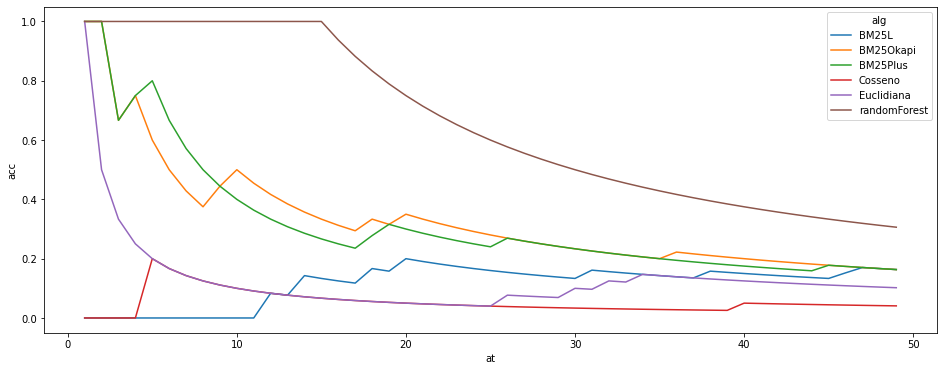

In [6]:
# print(gDF)
#Plot 1: Accurácia at
plt.figure(figsize=(16, 6))
df = pd.DataFrame(gDF,columns=['at','acc','alg'])
p = sns.lineplot(x='at',y='acc',hue='alg',data=df)
p.figure.savefig("output.pdf")

In [7]:
aux = []
p_id = label_map['sim']

for i,test in enumerate(vets_sparse):
    aux.append((i,bModel.classifier.algorithm.predict_proba(test)[0][p_id]))
aux.sort(key=operator.itemgetter(1),reverse=True)
# aux = aux[:2]
# print(aux)
print(data['resume-query'])
print('#########################')
for i,j in aux[:2]:
    print(j,data['result'][i][FEATURE])
    
print('#########################')
for i,j in aux[-4:]:
    print(j,data['result'][i][FEATURE])


Solid wastes are today one of the worst problems in the world, mainly because of the increase in volume and the high capacity of environmental contamination. This paper analyzes the possibility of use sawing granite wastes as alternative ceramic raw materials for the production of bricks and roof tiles. Samples were collected from wastes of several granites companies from the northeast region of Brazil. They were submitted to particle size and mineralogical characterization. Some ceramic compositions were prepared with granite waste and submitted to technological tests. Results indicated that the wastes have particle size distribution and mineralogical composition similar to conventional non-plastic ceramic raw materials. These wastes can be used in substitution of conventional raw materials in ceramic formulations in proportions up to 50%.
#########################
0.77 Solid wastes are today one of the worst problems in the world, mainly because of the increase in volume and the high

               x   y
alg                 
BM25L         49  49
BM25Okapi     49  49
BM25Plus      49  49
Cosseno       49  49
Euclidiana    49  49
randomForest  49  49
            alg      freq
0         BM25L  0.163265
1     BM25Okapi  0.163265
2      BM25Plus  0.163265
3       Cosseno  0.040816
4    Euclidiana  0.102041
5  randomForest  0.306122


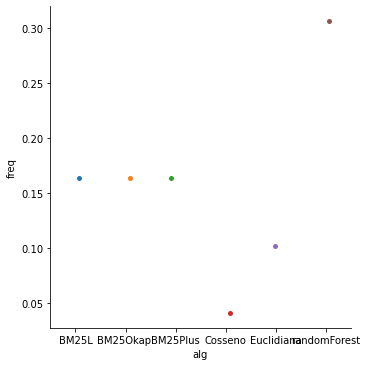

In [8]:
#Plot 2: Quantidade de elementos não relevantes no TOP N.

p_id = label_map['sim']

df = pd.DataFrame(columns=['alg', 'freq'])

algs = data_plot.groupby('alg').count()
print(algs)
_id = 0
for i in algs.iterrows():
    cont = 0
    for j in data_plot[data_plot['alg'] == i[0]].head(n=at).iterrows():
        if j[1][1] == p_id:
            cont += 1
    df2 = pd.DataFrame({'alg':i[0],'freq':cont/at},index=[_id])
    _id +=1
    df = df.append(df2,ignore_index=True)
    

print(df)
sns.catplot(x='alg',y='freq',hue='alg',data=df)